In [1]:
import numpy as np
import pandas as pd
import scipy as sp
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import roc_auc_score

In [2]:
df_pr = pd.read_csv("data_banknote_authentication.txt")
df_pr

,variance,skewness,curtosis,entropy,class
0,3.62160,8.66610,-2.8073,-0.44699,0
1,4.54590,8.16740,-2.4586,-1.46210,0
2,3.86600,-2.63830,1.9242,0.10645,0
3,3.45660,9.52280,-4.0112,-3.59440,0
4,0.32924,-4.45520,4.5718,-0.98880,0
...,...,...,...,...,...
1367,0.40614,1.34920,-1.4501,-0.55949,1
1368,-1.38870,-4.87730,6.4774,0.34179,1
1369,-3.75030,-13.45860,17.5932,-2.77710,1
1370,-3.56370,-8.38270,12.3930,-1.28230,1


In [3]:
data_gon = pd.DataFrame({'Number of datapoints missing': df_pr.isnull().sum()})
data_gon

,Number of datapoints missing
variance,0
skewness,0
curtosis,0
entropy,0
class,0


Shuffling data

In [4]:
np.random.seed(0)
df_pr = df_pr.iloc[np.random.permutation(len(df_pr))]
df_pr

,variance,skewness,curtosis,entropy,class
1023,-1.77130,-10.766500,10.218400,-1.004300,1
642,5.13210,-0.031048,0.326160,1.115100,0
1196,-2.01490,3.687400,-1.938500,-3.891800,1
31,1.48840,3.627400,3.308000,0.489210,0
253,5.28680,3.257000,-1.372100,1.166800,0
...,...,...,...,...,...
763,0.39012,-0.142790,-0.031994,0.350840,1
835,-0.94255,0.039307,-0.241920,0.315930,1
1216,0.60050,0.999450,-2.212600,0.097399,1
559,2.01650,-0.252460,5.170700,1.076300,0


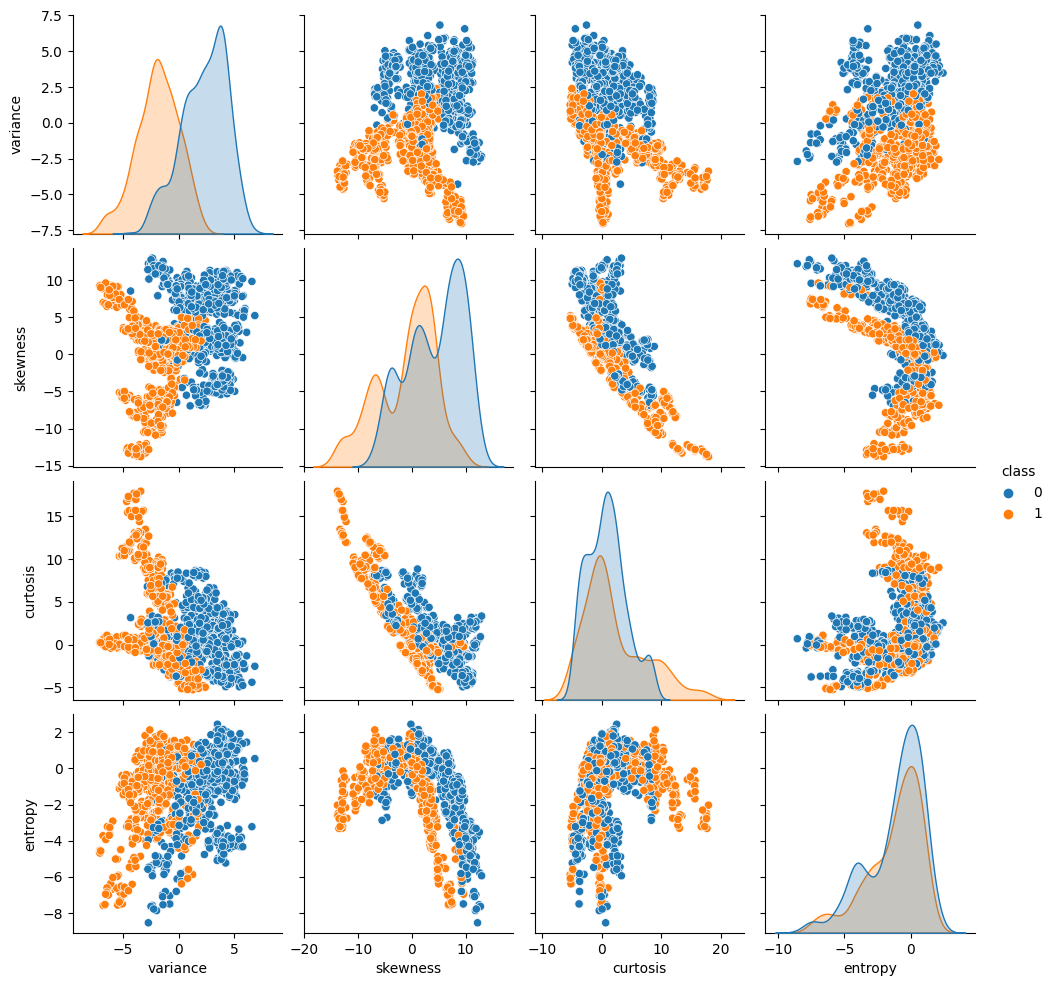

In [5]:
sns.pairplot(data=df_pr, hue='class')

In [6]:
plt.figure(figsize = (10,8))
sns.heatmap(data=df_pr.corr(), annot=True, cmap='coolwarm')

<AxesSubplot:>

Standardisation

In [7]:
df_pr.iloc[:, 0:4] = (df_pr.iloc[:, 0:4] - df_pr.iloc[:, 0:4].mean())/df_pr.iloc[:, 0:4].std()
df_pr

,variance,skewness,curtosis,entropy,class
1023,-0.775666,-2.161996,2.046569,0.089174,1
642,1.652746,-0.332831,-0.248599,1.097926,0
1196,-0.861358,0.300738,-0.774038,-1.285163,1
31,0.371000,0.290515,0.443239,0.800027,0
253,1.707165,0.227404,-0.642624,1.122533,0
...,...,...,...,...,...
763,-0.015343,-0.351870,-0.331696,0.734168,1
835,-0.484137,-0.320844,-0.380403,0.717552,1
1216,0.058663,-0.157249,-0.837634,0.613540,1
559,0.556770,-0.370556,0.875417,1.079459,0


In [8]:
class ORem: 
    def __init__(self, lq, uq):
        self.low_w = lq - 1.5*(uq - lq)
        self.high_w = uq + 1.5*(uq - lq)
    def removeOutlier(self, x):
        return (x if ((x <= self.high_w) & (x >= self.low_w)) 
        else (self.low_w if x < self.low_w else (self.high_w)))

In [9]:
def OutRem(dt, columns):
    for i in columns:
        q1 = dt[i].quantile(0.25)
        q3 = dt[i].quantile(0.75)
        outlier_remover = ORem(q1, q3)
        dt[i] = dt[i].apply(outlier_remover.removeOutlier)
    return dt

In [10]:
x_train = df_pr[['variance',	'skewness',	'curtosis',	'entropy']].to_numpy()
x_train = np.append(x_train, np.ones((x_train.shape[0], 1)), axis=1)
y_train = df_pr['class'].to_numpy().reshape(x_train.shape[0], 1)
print(x_train.shape, y_train.shape)

(1372, 5) (1372, 1)


In [11]:
split_perc = 0.7
lindex = x_train.shape[0]*split_perc
test_x = x_train[int(lindex):, :]
test_y = y_train[int(lindex):, :]
train_x = x_train[0:int(lindex), :]
train_y = y_train[0:int(lindex), :]
print(x_train.shape, y_train.shape, test_x.shape, test_y.shape)

(1372, 5) (1372, 1) (412, 5) (412, 1)


In [12]:
def sigmoid(x):
  return 1/(1+np.exp(-x))

In [13]:
def cfunction(X, y, theta):
    var_x = sigmoid(np.dot(X, theta))
    cost = (np.dot(-y.T, np.log(var_x)) + np.dot(-(1 - y).T, np.log(1 - var_x))) / X.shape[0]
    return cost

In [14]:
def gradnt(X, Y, theta):
  var_sig = sigmoid(np.dot(X, theta)) - Y
  cost = cfunction(X, Y, theta)
  costarr.append(cost)
  grad = np.dot(X.T, var_sig) / X.shape[0]
  return grad

In [15]:
def grad_desc(X, y, start, learn_rate, n_iter):
    theta = start
    for _ in range(n_iter):
        diff = -learn_rate * gradnt(X, y, theta)
        theta += diff
    return theta

In [16]:
costarr = []
theta = grad_desc(train_x, train_y, np.zeros((x_train.shape[1], 1)), 0.01, 50000)
predicted = sigmoid(np.dot(test_x, theta))
y_pred = predicted > 0.5
y_pred = y_pred.astype(int)
m = test_y.shape[0]
itr = np.arange(0, len(costarr), 1)
plt.scatter(itr, costarr)
plt.title('Cost value and iterations')
plt.xlabel('Iterations')
plt.ylabel('Cost')
accuracy = (test_y == y_pred).sum() / m
print('Accuracy is', accuracy)

Accuracy is 1.0


In [17]:
def finding_f1(y,y_hat):
    tp,tn,fp,fn = 0,0,0,0
    for i in range(len(y)):
        if y[i] == 1 and y_hat[i] == 1:
            tp += 1
        elif y[i] == 1 and y_hat[i] == 0:
            fn += 1
        elif y[i] == 0 and y_hat[i] == 1:
            fp += 1
        elif y[i] == 0 and y_hat[i] == 0:
            tn += 1
    prc = tp/(tp+fp)
    rcl = tp/(tp+fn)
    f1_score = 2*prc*rcl/(prc+rcl)
    return f1_score

In [18]:
print('F1 score:', finding_f1(test_y, y_pred))

F1 score: 1.0


In [19]:
print('ROC AUC score:', roc_auc_score(test_y, y_pred))

ROC AUC score: 1.0
